# Example notebook

In [140]:
%matplotlib inline
from skimage import transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from floortrans.models import get_model
from floortrans.loaders import FloorplanSVG, DictToTensor, Compose, RotateNTurns
from floortrans.plotting import segmentation_plot, polygons_to_image, draw_junction_from_dict, discrete_cmap
discrete_cmap()
from floortrans.post_prosessing import split_prediction, get_polygons, split_validation
from mpl_toolkits.axes_grid1 import AxesGrid

rot = RotateNTurns()
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]

data_folder = 'data/cubicasa5k/'
data_file = 'test.txt'
normal_set = FloorplanSVG(data_folder, data_file, format='txt', original_size=True)
data_loader = DataLoader(normal_set, batch_size=1, num_workers=0)
data_iter = iter(data_loader)
# Setup Model
model = get_model('hg_furukawa_original', 51)

n_classes = 44
split = [21, 12, 11]
model.conv4_ = torch.nn.Conv2d(256, n_classes, bias=True, kernel_size=1)
model.upsample = torch.nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=4)
# checkpoint = torch.load('model_best_val_loss_var.pkl')

# model.load_state_dict(checkpoint['model_state'])
# model.eval()
# model.cuda()
# print("Model loaded.")

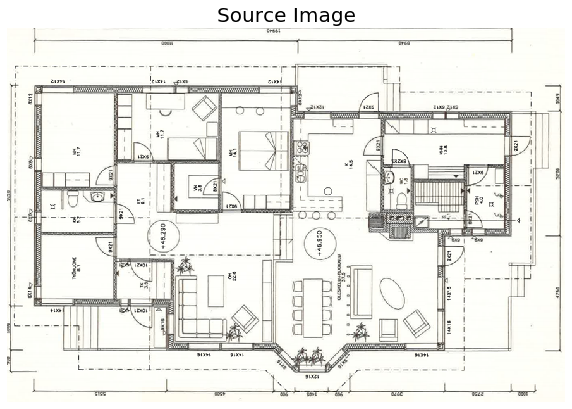

In [141]:
val = next(data_iter)
junctions = val['heatmaps']
folder = val['folder'][0]
image = val['image']#.cuda()
label = val['label']
np_img = np.moveaxis(image[0].cpu().data.numpy(), 0, -1) / 2 + 0.5
plt.figure(figsize=(10,10))
plt.title('Source Image', fontsize=20)
plt.axis('off')
plt.imshow(np_img)
plt.show()

## The SVG floorplan
If the floorplan includes two floors the other floor might not be visible, but it will be parsed never the less.

In [142]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url=data_folder+folder[1:]+"model.svg", width=800)

In [143]:
data_folder+folder[1:]+"model.svg"

'data/cubicasa5k/high_quality_architectural/1191/model.svg'

## Parsed labels

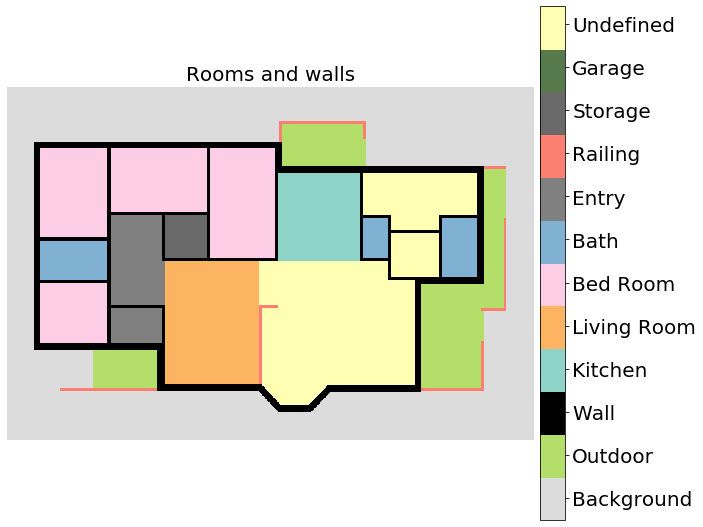

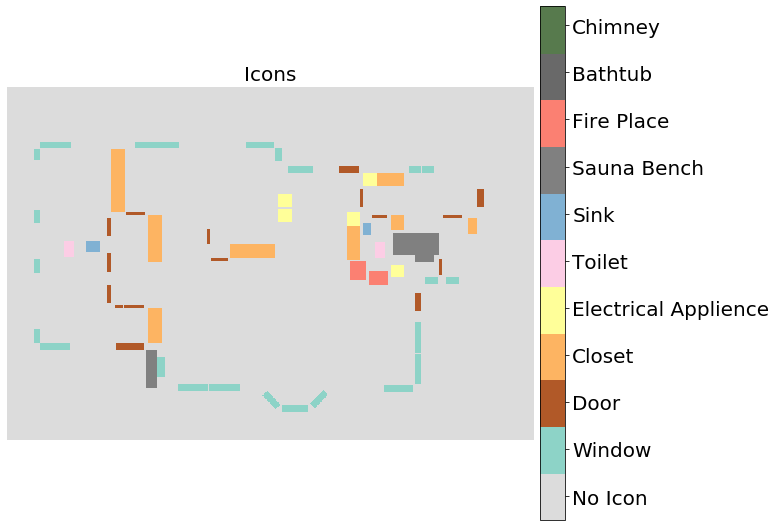

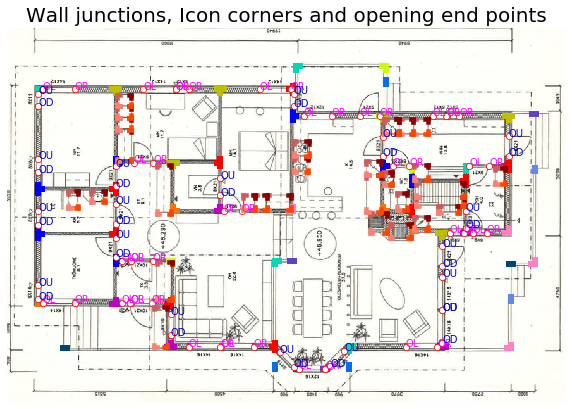

In [41]:
label_np = label.data.numpy()[0]
plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Rooms and walls', fontsize=20)
ax.axis('off')
n_rooms = 12
rseg = ax.imshow(label_np[0], cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Icons', fontsize=20)
ax.axis('off')
n_icons = 11
iseg = ax.imshow(label_np[1], cmap='icons', vmin=0, vmax=n_icons-0.1)
cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(icon_classes, fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Wall junctions, Icon corners and opening end points', fontsize=20)
ax.axis('off')
ax.imshow(np_img)
h, w, _ = np_img.shape
draw_junction_from_dict(junctions, w, h, size=0.3, fontsize=10)
plt.show()

In [148]:
for subset in ['train', 'val','test']:
    data_file = f'{subset}.txt'
    normal_set = FloorplanSVG(data_folder, data_file, format='txt', original_size=True)
    data_loader = DataLoader(normal_set, batch_size=1, num_workers=0)
    
    with open(f'./EDA_results/{subset}_icons.pkl', 'rb') as f:
        poly_dict = pickle.load(f)
    
    poly_dict[0] = len(data_loader)
    
    pkl_path = f'./EDA_results/{subset}_icons.pkl'
    with open(pkl_path, 'wb') as pkl_file:
        pickle.dump(poly_dict, pkl_file)

    
    
    

In [179]:
import copy
import cv2
x = copy.copy(label_np[0])
x[label_np[0] != 1] = 0 

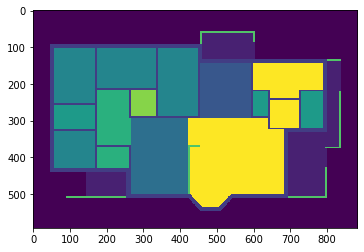

In [180]:
plt.imshow(label_np[0])

In [181]:
yimg = x.astype(np.uint8)

In [182]:
contours, hierarchy = cv2.findContours(yimg.copy(),\
                                       cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

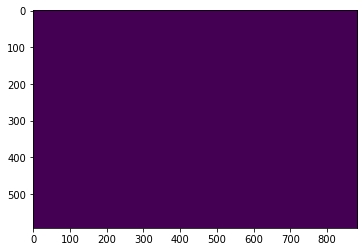

0 0


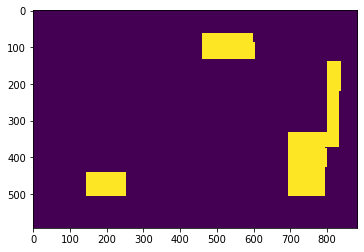

1 3


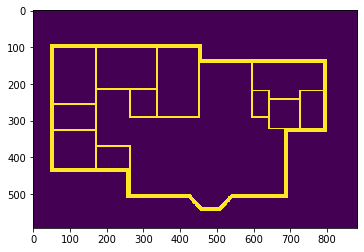

2 13


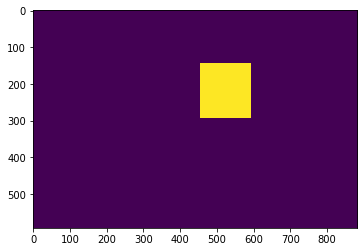

3 1


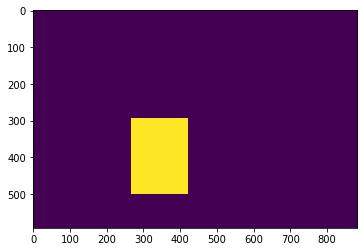

4 1


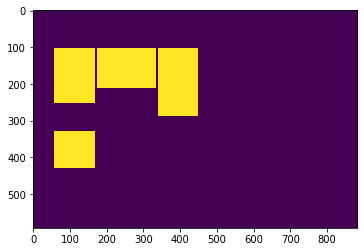

5 4


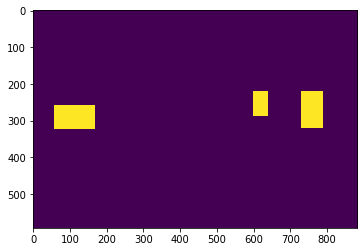

6 3


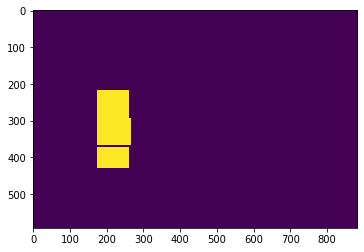

7 2


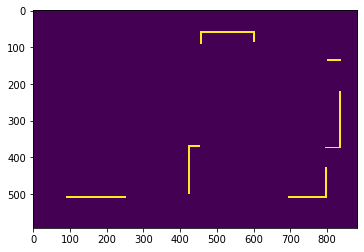

8 6


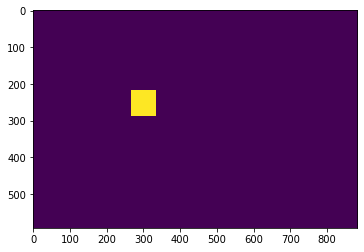

9 1


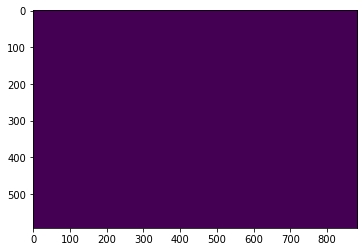

10 0


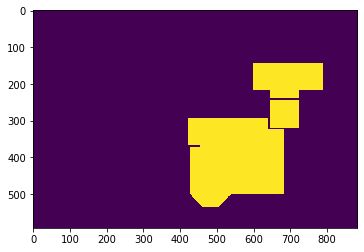

11 3
time: 1.8289742469787598


In [183]:
import time
start = time.time()
for i in range(12):
    x = copy.copy(label_np[0])
    x[label_np[0] != i] = 0 
    x = x.astype(np.uint8)
    plt.imshow(x)
    plt.show()
    contours, _ = cv2.findContours(x,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    print(i,len(contours))

print('time:', time.time() - start)
    
    
    

In [23]:
from collections import defaultdict
import pickle
val_room_dict = defaultdict(int)

normal_set = FloorplanSVG(data_folder, 'val.txt', format='txt', original_size=True)
data_loader = DataLoader(normal_set, batch_size=1, num_workers=0)

start = time.time()
for t,val in enumerate(data_loader):
    label_np = val['label'].data.numpy()[0][0]
    for i in range(12):
        x = copy.copy(label_np)
        x[label_np != i] = 0 
        x = x.astype(np.uint8)
        contours, _ = cv2.findContours(x,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
        val_room_dict[i]+=len(contours)
    
    if t%100 == 0: 
        print(t,'finished', time.time() - start)


pkl_path = './EDA_results/val_rooms.pkl'
with open(pkl_path, 'wb') as pkl_file:
    pickle.dump(val_room_dict, pkl_file)



0 finished 0.28446483612060547
100 finished 71.78619599342346
200 finished 133.96367692947388
300 finished 188.02249598503113


In [105]:
test_icon_dict

defaultdict(int,
            {0: 0,
             1: 3418,
             2: 4066,
             3: 1979,
             4: 1713,
             5: 590,
             6: 1026,
             7: 423,
             8: 155,
             9: 29,
             10: 58})

In [24]:
val_icon_dict = defaultdict(int)
start = time.time()
for t,val in enumerate(data_loader):
    label_np = val['label'].data.numpy()[0][1]
    for i in range(11):
        x = copy.copy(label_np)
        x[label_np != i] = 0 
        x = x.astype(np.uint8)
        contours, _ = cv2.findContours(x,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
        val_icon_dict[i]+=len(contours)
    
    if t%100 == 0:
        print(t,'finished', time.time() - start)


import pickle
pkl_path = './EDA_results/val_icons.pkl'
with open(pkl_path, 'wb') as pkl_file:
    pickle.dump(val_icon_dict, pkl_file)

0 finished 0.27704811096191406
100 finished 70.91380500793457
200 finished 132.2965910434723
300 finished 186.93266677856445


# Balance check

In [86]:
import seaborn as sns
with open('./EDA_results/train_rooms.pkl', 'rb') as f:
    train_room_dict = pickle.load(f)

In [88]:
import seaborn as sns
with open('./EDA_results/test_rooms.pkl', 'rb') as f:
    test_room_dict = pickle.load(f)

In [160]:
def seg_counts(polygon = 'room', subset = 'train'):
    with open(f'./EDA_results/{subset}_{polygon}s.pkl', 'rb') as f:
        poly_dict = pickle.load(f)
        
        
    poly_arr = [poly_dict[i] for i in range(len(poly_dict))]
    
    if polygon == 'room':
        
        room_classes_vis = [room_classes[1]]+room_classes[3:]
        poly_arr_vis = [poly_arr[1]]+ poly_arr[3:]
            
        plt.figure(figsize = (10,5))
        plt.bar(x = room_classes_vis, height = poly_arr_vis)
        plt.xticks(rotation = 45)
        plt.title(f'{subset} set room counts')
        plt.xlabel('room types')
        plt.ylabel('counts')
        plt.show()
        
    elif polygon == 'icon':
        
        icon_classes_vis = icon_classes[1:]
        poly_arr_vis =  poly_arr[1:]
        plt.figure(figsize = (10,5))
        plt.bar(x = icon_classes_vis, height = poly_arr_vis)
        plt.xticks(rotation = 45)
        plt.title(f'{subset} set room counts')
        plt.xlabel('icon types')
        plt.ylabel('counts')
        plt.show()

    

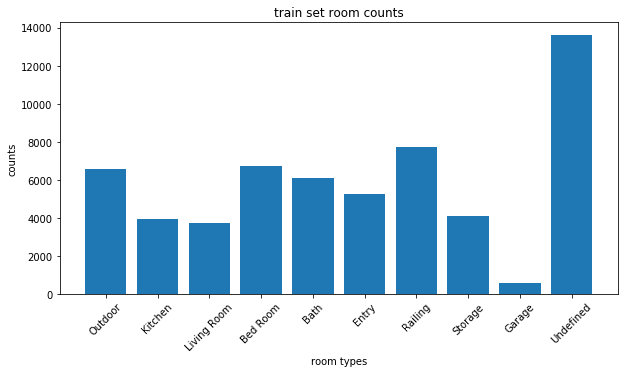

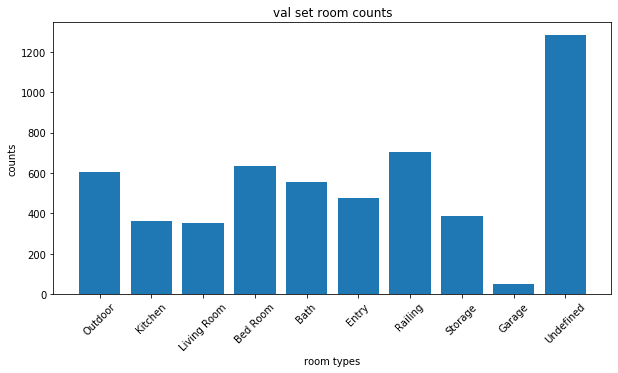

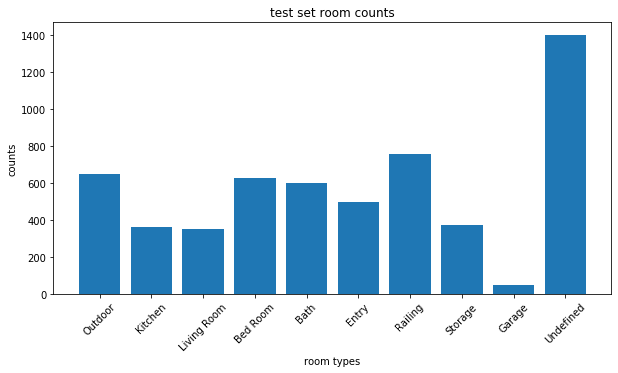

In [161]:
seg_counts('room', 'train')
seg_counts('room', 'val')
seg_counts('room', 'test')

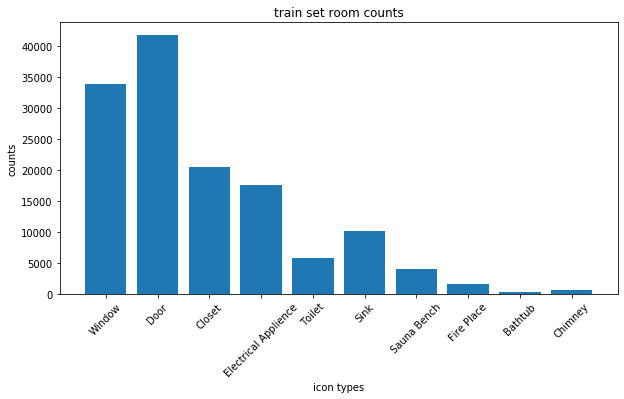

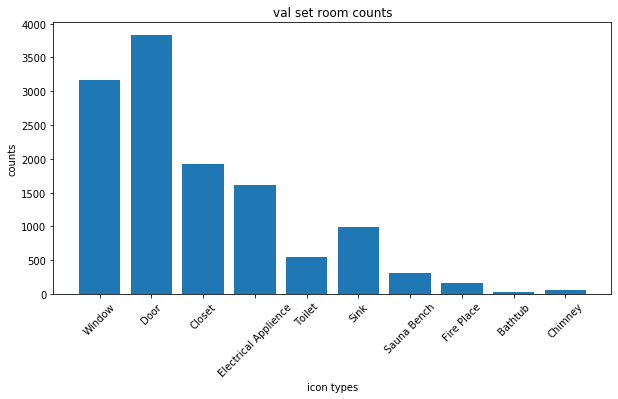

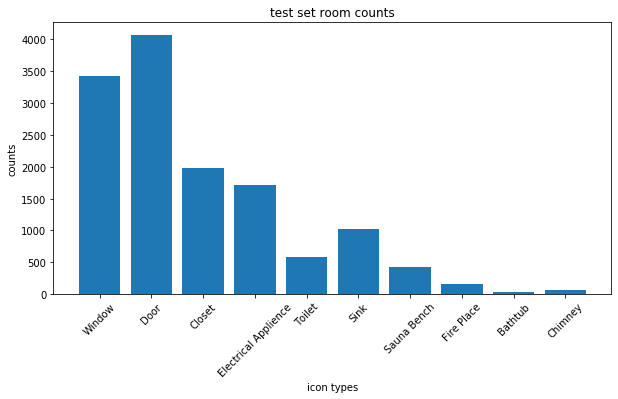

In [162]:
seg_counts('icon', 'train')
seg_counts('icon', 'val')
seg_counts('icon', 'test')

In [194]:
def combine_counts(polygon = 'room', prop = False):
    
    dict_list = []
    poly_arrs = []
    
    for subset in ['train','val','test']:
        with open(f'./EDA_results/{subset}_{polygon}s.pkl', 'rb') as f:
            subset_dict = pickle.load(f)
        dict_list.append(subset_dict)
        if polygon == 'room':
            arr_temp = [subset_dict[i] for i in range(len(subset_dict))]
            arr = [arr_temp[1]]+arr_temp[3:]   
            
        elif polygon == 'icon':
            arr = [subset_dict[i] for i in range(1,len(subset_dict))]
        
        if prop:
            arr = [x/subset_dict[0] for x in arr]
        
        poly_arrs.append(arr)
            
    
    
    if polygon == 'room':
        
        room_classes_vis = [room_classes[1]]+room_classes[3:]
        
        len_data = len(room_classes_vis)
        width = 0.3
            
        plt.figure(figsize = (10,6))
        
        plt.bar(np.arange(len_data), poly_arrs[0], width=width, label = 'train')
        plt.bar(np.arange(len_data)+ width, poly_arrs[1], width=width, label = 'val')
        plt.bar(np.arange(len_data)+ 2*width, poly_arrs[2], width=width, label = 'test')
        
        
        if prop:
            plt.title('dataset avg room counts')
            plt.ylabel('avg counts')
        else:
            plt.title('dataset room counts')
            plt.ylabel('counts')
        
        plt.xlabel('room types')
        
        plt.xticks(np.arange(len_data)+width, room_classes_vis, rotation = 45)
        plt.legend()
        plt.show()
        
    elif polygon == 'icon':
        
        icon_classes_vis = icon_classes[1:]
        
        len_data = len(icon_classes_vis)
        width = 0.3
            
        plt.figure(figsize = (10,6))
        
        plt.bar(np.arange(len_data), poly_arrs[0], width=width, label = 'train')
        plt.bar(np.arange(len_data)+ width, poly_arrs[1], width=width, label = 'val')
        plt.bar(np.arange(len_data)+ 2*width, poly_arrs[2], width=width, label = 'test')
        
        if prop:
            plt.title('dataset avg icon counts')
            plt.ylabel('avg counts')
        else:
            plt.title('dataset icon counts')
            plt.ylabel('counts')
        
        
        plt.xlabel('icon types')
        plt.xticks(np.arange(len_data)+width, icon_classes_vis, rotation = 45)
        plt.legend()
        plt.show()
        
    

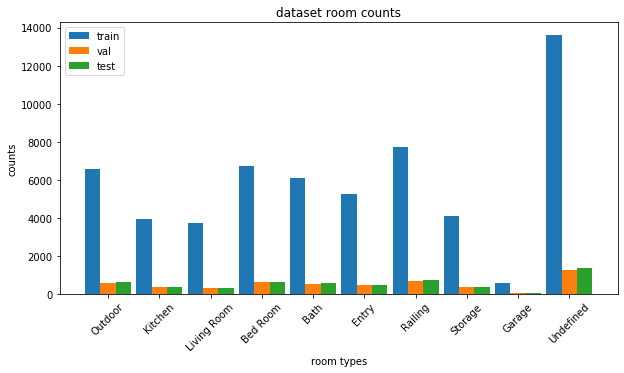

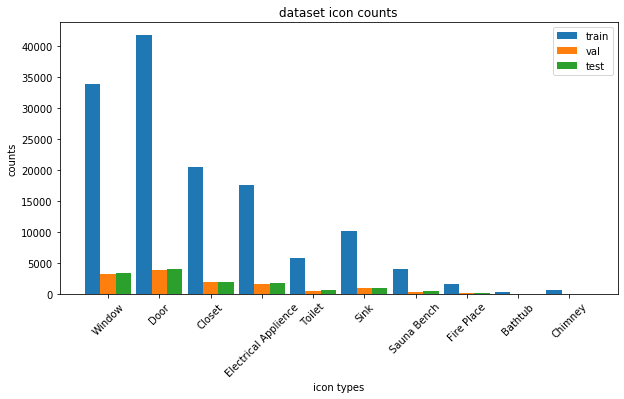

In [168]:
combine_counts('room')
combine_counts('icon')

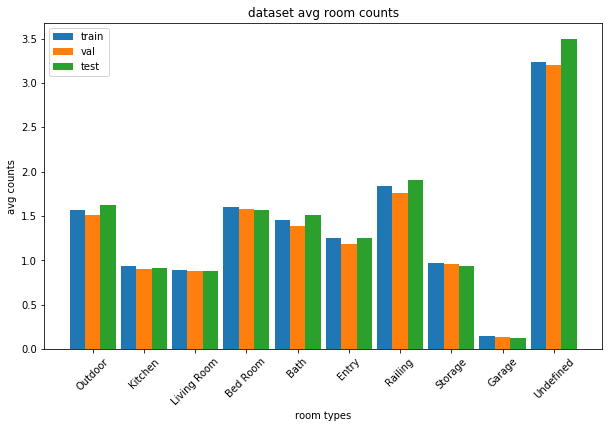

In [195]:
combine_counts('room', True)

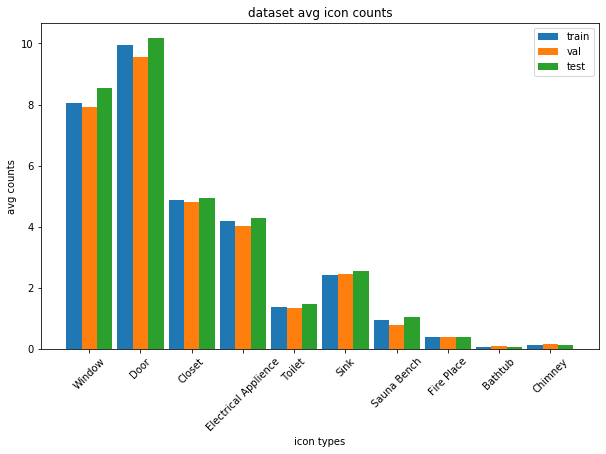

In [196]:
combine_counts('icon', True)

In [191]:
def total_counts(polygon = 'room'):
    
    dict_list = []
    poly_arrs = []
    
    for subset in ['train','val','test']:
        with open(f'./EDA_results/{subset}_{polygon}s.pkl', 'rb') as f:
            subset_dict = pickle.load(f)
        dict_list.append(subset_dict)
        if polygon == 'room':
            arr_temp = [subset_dict[i] for i in range(len(subset_dict))]
            arr = [arr_temp[1]]+arr_temp[3:]   
            
        elif polygon == 'icon':
            arr = [subset_dict[i] for i in range(1,len(subset_dict))]
        
        poly_arrs.append(arr)
        
    poly_sums = np.array(poly_arrs).sum(axis = 0)
    
    if polygon == 'room':
        
        room_classes_vis = [room_classes[1]]+room_classes[3:]
            
        plt.figure(figsize = (10,6))
        plt.bar(x = room_classes_vis, height = poly_sums)
        plt.xticks(rotation = 45)
        plt.title('dataset total room counts')
        plt.xlabel('room types')
        plt.ylabel('counts')
        plt.show()
        
    elif polygon == 'icon':
        
        icon_classes_vis = icon_classes[1:]
        plt.figure(figsize = (10,6))
        plt.bar(x = icon_classes_vis, height = poly_sums)
        plt.xticks(rotation = 45)
        plt.title('dataset total icon counts')
        plt.xlabel('icon types')
        plt.ylabel('counts')
        plt.show()


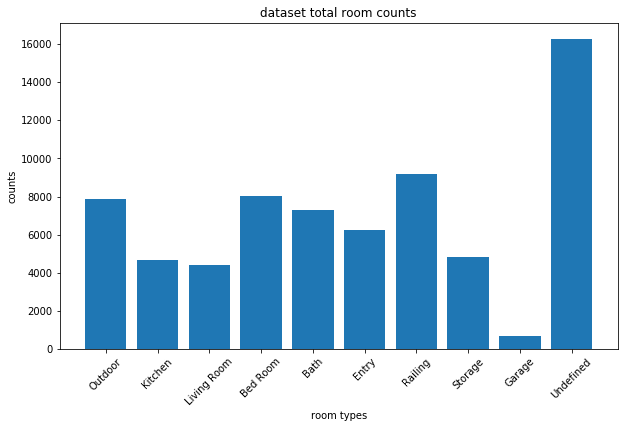

In [192]:
total_counts('room')

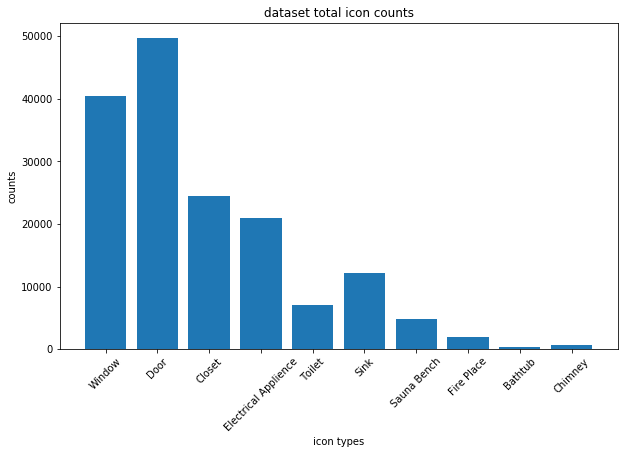

In [193]:
total_counts('icon')